In [1]:
# Import Package
import pandas as pd
import json
import re
import string
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')
%matplotlib inline

<ipython-input-1-54dd48cf99bd>:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# import data
data = pd.read_csv('hasilprediksi.csv')
data = data.drop_duplicates(subset=['content','sentiment_score']) # in case of duplicated reviews
data.reset_index(inplace=True)

In [3]:
data['wordCount'] = data['content'].apply(lambda x: len(x.split()))
data.head(2)

,index,content,sentiment_score,predict_score,wordCount
0,0,"Love the game, hate the energy system. Compared to other gacha game, GI daily energy is too limited. All players will reach endgame at some point. At that point what can they do? Login, play 8 minutes and all resins are used up? Exploring? Lol, good luck getting meaningful artifacts, enough exp books, enough mora (gold) to build a unit. --- If Mihoyo wants GI to be focused more on exploration, please make exploring more rewarding to balance out the bad energy system.",Neutral,Neutral,83
1,1,"Overheats and drains phones extremely fast even on the lowest setting graphically. Please, please make it better optimized, I really wanna actually play for longer than an hour without my phone dying all the time from it.",Neutral,Neutral,37


## Overview

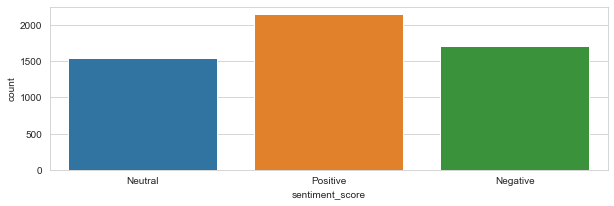

In [4]:
# Reviews count per score

plt.figure(figsize=(10,3))
sns.countplot(x=data['sentiment_score'])

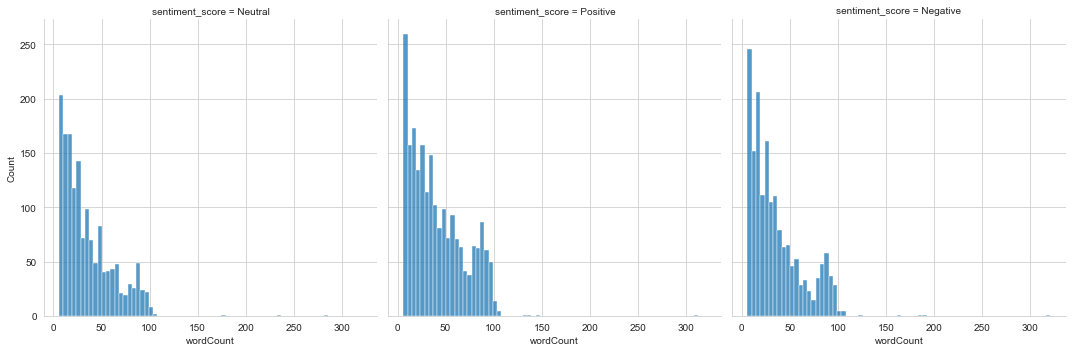

In [5]:
# Number of words in the reviews per score

sns.displot(x=data['wordCount'],col=data['sentiment_score'])

In [6]:
# num of word in the reviews

data.groupby('sentiment_score')['wordCount'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_score,,,,,,,,
Negative,1714.0,36.018670,27.390832,6.0,15.0,28.0,49.0,321.0
Neutral,1545.0,35.755340,26.592145,6.0,15.0,27.0,50.0,285.0
Positive,2147.0,41.475082,28.003423,6.0,18.0,35.0,61.0,309.0


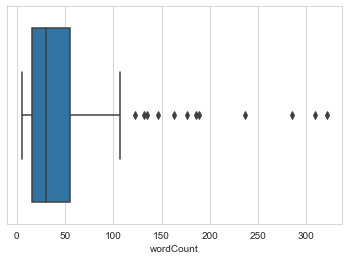

In [7]:
# boxplot

sns.boxplot(x=data['wordCount'])

# Processing

In [8]:
# Tokenizer

with open('cont_en.json') as file:         # import contraction dictionary
    contEn = json.load(file)
    
c_re = re.compile('(%s)' % '|'.join(contEn.keys()))

def expandContractions(text, c_re=c_re):         # expanding contractiion into full form word. ex: won't -> will not
    def replace(match):
        return contEn[match.group(0)]
    return c_re.sub(replace, text.lower())

def stars(text):
    if '*' in text:
        word = text.replace('*',' stars') # replacing * symbol with "star"
    else:
        word = text
    return word

def num2word(text):                        #convert number to string
    if len(text) == 1 and text in '12345':
        if text == '1':
            word = 'one'
        elif text == '2':
            word = 'two'
        elif text == '3':
            word = 'three'
        elif text == '4':
            word = 'four'
        elif text == '5':
            word = 'five'
        else:
            word = text
    else:
        word = text
    return word

def lemma(word, tags=['NOUN','PROPN','VERB']):    # spaCy Lemmatizer
    lemma_doc = nlp(" ".join(word)) 
    lemma_text = [token.text if '_' in token.text else token.lemma_ for token in lemma_doc if token.pos_ in tags]
    return lemma_text

In [9]:
# spacy stopword

nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words -= {"one", "two","three","four","five"} #removing these word from stop_word
stopword = list(STOP_WORDS)

#=== custom stopword ==========

stopword2 = stopword
stopword2.extend(['great','good','like','game','feel','thing','hour','time','play']) # add words into stopword list

In [10]:
def clean_token(text):
    text = stars(text)
    text = expandContractions(text)
    text = re.split(r'\W+',text)
    text = [num2word(x) for x in text]
    text = [x for x in text if x not in string.punctuation]
    text = ["have" if x == "ve" else x for x in text]
    text = ["game" if x == "games" else x for x in text]
    text = ["phone" if x == "mobile" else x for x in text]
    text = ' '.join(text).replace('one one','1.1').split()
    text = [x for x in text if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    return text

In [11]:
# creating token columns

data['token'] = data['content'].apply(clean_token)

In [12]:
# add n-grams

bigram = gensim.models.Phrases(list(data['token']), min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [13]:
# lemmatize n-grams and removing stopword from n-grams (double check)

def bigrams(bow):
    text = [x for x in bow if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    text = bigram[text]
    text = lemma(text)
    return text

def unigrams(bow):
    text = [x for x in bow if x not in stopword2 and len(x) > 1 and len(x) <= 45]
    text = lemma(text)
    return text

In [14]:
data['bigram_tag'] = data['token'].apply(bigrams)
data['unigram_tag'] = data['token'].apply(unigrams)

## Word Cloud

In [15]:
pos_list = []
for i in data[data.sentiment_score == 'Positive']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            pos_list.append(j)

Posfreq = nltk.FreqDist(pos_list)
print("Most Common words in Positive Reviews")
print(Posfreq.most_common(100))
print()

net_list = []
for i in data[data.sentiment_score == 'Neutral']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            net_list.append(j)

Netfreq = nltk.FreqDist(net_list)
print("Most Common words in Neutral Reviews")
print(Netfreq.most_common(100))
print()

neg_list = []
for i in data[data.sentiment_score == 'Negative']['bigram_tag']:
    for j in i:
        if j not in stopword2:
            neg_list.append(j)

Negfreq = nltk.FreqDist(neg_list)
print("Most Common words in Negative Reviews")
print(Negfreq.most_common(100))

Most Common words in Positive Reviews
[('phone', 725), ('graphic', 426), ('character', 396), ('love', 389), ('story', 298), ('gameplay', 214), ('need', 214), ('problem', 208), ('fun', 207), ('lot', 184), ('open_world', 174), ('pc', 151), ('control', 144), ('hope', 144), ('fix', 143), ('want', 141), ('issue', 136), ('experience', 134), ('wish', 129), ('add', 129), ('update', 126), ('world', 123), ('enjoy', 112), ('quest', 112), ('try', 110), ('gacha', 109), ('lag', 105), ('work', 104), ('way', 102), ('rpg', 102), ('bit', 101), ('level', 99), ('think', 97), ('run', 96), ('five_star', 92), ('look', 92), ('player', 91), ('resin', 89), ('thank', 86), ('five_stars', 83), ('come', 81), ('use', 80), ('system', 79), ('device', 78), ('start', 76), ('download', 76), ('option', 75), ('find', 72), ('people', 71), ('explore', 71), ('change', 70), ('friend', 67), ('support', 67), ('bug', 67), ('wait', 65), ('know', 64), ('rate', 63), ('mihoyo', 63), ('co_op', 62), ('storyline', 61), ('ps4', 60), ('re

In [16]:
#turn the word list into a str for wordcloud generation
# pos = ' '.join(w for w in pos_list)
# net = ' '.join(w for w in net_list) 
# neg = ' '.join(w for w in neg_list)

# Generate wordcloud:
wcdpos = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Posfreq)
wcdnet = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Netfreq)
wcdneg = wordcloud.WordCloud(width = 2000, height=1000, max_words = 60, stopwords=stopword2,background_color="white").generate_from_frequencies(Negfreq)

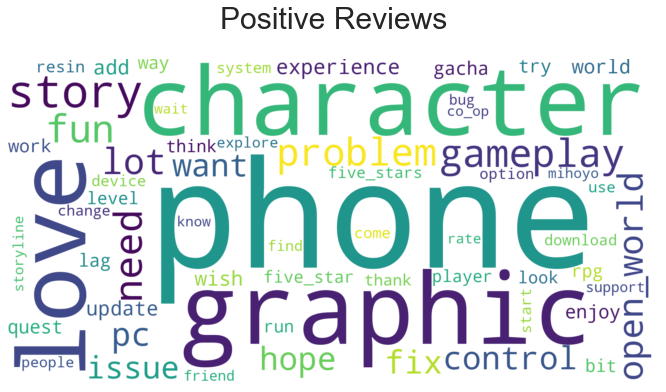

In [17]:
plt.figure(figsize=(16,6))
plt.title("Positive Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdpos, interpolation='bilinear')
plt.axis("off")
plt.show()

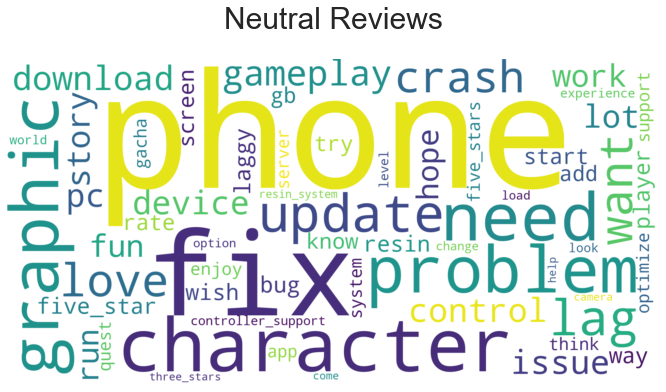

In [18]:
plt.figure(figsize=(16,6))
plt.title("Neutral Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdnet, interpolation='bilinear')
plt.axis("off")
plt.show()

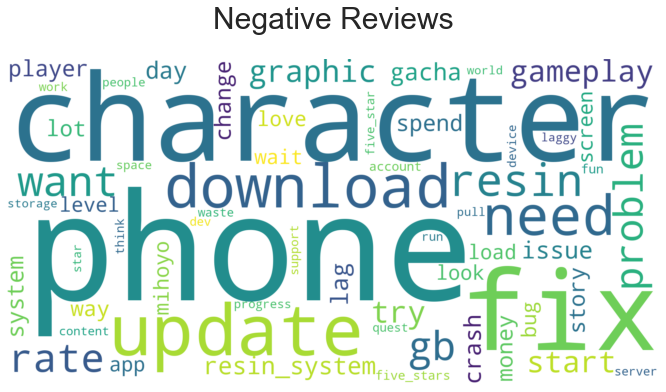

In [19]:
plt.figure(figsize=(16,6))
plt.title("Negative Reviews", fontdict={'fontsize': 30},pad=30)
plt.imshow(wcdneg, interpolation='bilinear')
plt.axis("off")
plt.show()

# Latent Dirichlet Allocation - Topic Modelling

In [20]:
doc = list(data['bigram_tag']) #bag of word
id2word = corpora.Dictionary(doc) # create dictionary
texts = doc # create cropus
corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
# Build LDA model
lda = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=6,
                       random_state=42,
                       eval_every=None,
                       chunksize=1000,
                       passes=100,
                       minimum_probability=0.05,
                       gamma_threshold=0.05,
                       alpha=0.08,
                       per_word_topics=True)

In [22]:
# Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))

# Coherence Score
coherenceLda = CoherenceModel(model=lda, texts=doc, dictionary=id2word, coherence='c_v')
coherence = coherenceLda.get_coherence()
print('\nCoherence Score: ', coherence)
print()

# list of n-topics
pprint(lda.print_topics())


Perplexity:  -7.136512681448027

Coherence Score:  0.4814525467857898

[(0,
  '0.029*"character" + 0.022*"resin" + 0.018*"need" + 0.016*"rate" + '
  '0.012*"gacha" + 0.012*"resin_system" + 0.011*"money" + 0.010*"system" + '
  '0.010*"level" + 0.010*"get"'),
 (1,
  '0.024*"character" + 0.013*"quest" + 0.012*"bug" + 0.011*"add" + '
  '0.011*"enemy" + 0.011*"fight" + 0.011*"think" + 0.010*"need" + '
  '0.009*"friend" + 0.008*"button"'),
 (2,
  '0.037*"update" + 0.036*"download" + 0.022*"gb" + 0.022*"fix" + '
  '0.019*"problem" + 0.014*"get" + 0.013*"say" + 0.013*"app" + 0.012*"load" + '
  '0.011*"take"'),
 (3,
  '0.076*"phone" + 0.024*"lag" + 0.023*"graphic" + 0.016*"play" + '
  '0.016*"device" + 0.014*"fix" + 0.014*"laggy" + 0.013*"run" + '
  '0.012*"problem" + 0.011*"love"'),
 (4,
  '0.054*"phone" + 0.023*"control" + 0.023*"pc" + 0.020*"support" + '
  '0.015*"controller_support" + 0.012*"fix" + 0.012*"love" + 0.012*"camera" + '
  '0.011*"crash" + 0.011*"issue"'),
 (5,
  '0.031*"graphic

In [23]:
# Topic visualization

pyLDAvis.enable_notebook()
visualTopic = pyLDAvis.gensim.prepare(lda, corpus, id2word, sort_topics=False)
visualTopic

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.157655 -0.145561  1       1        24.223577
1     -0.085538  0.000950  2       1        12.512557
2      0.189591 -0.166047  3       1        16.032684
3      0.130793  0.090645  4       1        18.828390
4      0.080319  0.132080  5       1        13.336740
5     -0.157510  0.087934  6       1        15.066046, topic_info=           Term         Freq        Total Category  logprob  loglift
37   phone       1413.000000  1413.000000  Default  30.0000  30.0000
43   download    334.000000   334.000000   Default  29.0000  29.0000
135  update      447.000000   447.000000   Default  28.0000  28.0000
29   resin       303.000000   303.000000   Default  27.0000  27.0000
96   character   796.000000   796.000000   Default  26.0000  26.0000
..         ...          ...          ...       ...      ...      ...
535  quest       47.468620    207.789398   Topic6  -5.2129   0.4163 
97   control     49.476589    251.966400   Topic6  -5.1714   0.2649 
109  weapon      40.013023    119.602264   Topic6  -5.3837   0.7978 
63   experience  40.999115    217.180527   Topic6  -5.3594   0.2255 
182  level       40.478546    204.146484   Topic6  -5.3722   0.2747 

[416 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
821   4      0.949929  3gb_ram        
320   4      0.987006  60fps          
1296  6      0.872194  absolutely_love
610   1      0.088532  account        
610   2      0.201210  account        
...  ..           ...      ...        
274   6      0.176558  xbox           
1839  5      0.047437  zelda          
1839  6      0.901307  zelda          
1668  4      0.069051  zoom           
1668  5      0.897658  zoom           

[760 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [24]:
# Topic per reviews

def whattopic(model=lda, corpus=corpus, texts=data):
    # Init output
    topicreviews = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Topic Contribution and Keywords for reviews
        for j, (n_topic, contri_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(n_topic)
                keywords = ", ".join([word for word, prop in wp])
                topicreviews = topicreviews.append(pd.Series([int(n_topic), round(contri_topic,3), keywords]), ignore_index=True)
            else:
                break
    topicreviews.columns = ['topic', 'topicContribution', 'topicKeyword']

    # content to the end of the output
    contents = pd.Series(texts)
    topicreviews = pd.concat([topicreviews, contents], axis=1)
    return topicreviews

In [25]:
data_topic = whattopic(model=lda, corpus=corpus, texts=doc)

In [26]:
topicReviews = data_topic.reset_index()
topicReviews.columns = ['reviews', 'topic', 'topicContribution', 'topicKeyword', 'content']

# Get keyword for each topic
# for i in topicReviews.topic.unique():
#     print(f'topic {i}:')
#     print('keys : ' + topicReviews[topicReviews['topic']==i]['topicKeyword'].unique())

## Topic Labelling:

#### topic 0.0: Resin/Stamina System
keys : ['character, resin, need, rate, gacha, resin_system, money, system, level, get']

#### topic 1.0: Quest and Co-op Mode
keys : ['character, quest, bug, add, enemy, fight, think, need, friend, button']

#### topic 2.0: Update Issue
keys : ['update, download, gb, fix, problem, get, say, app, load, take']

#### topic 3.0: Device Issue
keys : ['phone, lag, graphic, play, device, fix, laggy, run, problem, love']

#### topic 4.0: Mobile gaming experience
keys : ['phone, control, pc, support, controller_support, fix, love, camera, crash, issue']

#### topic 5.0: Game Features
keys : ['graphic, story, love, open_world, character, play, fun, gameplay, world, rpg']

In [27]:
topicReviews['original'] = data['content']
topicReviews['wordCount'] = topicReviews['content'].apply(lambda x: len(x))
topicReviews['score'] = data['sentiment_score']

In [28]:
#exclude 0 words from dataframe

topicReviews = topicReviews[topicReviews.wordCount > 2]

In [29]:
contribreview = pd.DataFrame()

for i in topicReviews.topic.unique():
    temp = topicReviews[topicReviews['topic'] == i].sort_values('topicContribution',ascending=0).head(1)
    contribreview = pd.concat([contribreview, temp ])

In [30]:
# most contirbuting reviews for each topics
contribreview.sort_values('topic')

,reviews,topic,topicContribution,topicKeyword,content,original,wordCount,score
1959,1959,0.0,0.995,"character, resin, need, rate, gacha, resin_system, money, system, level, get","[developer, refuse, allow, grow, resin_system, system, limit, content, kill, way, player, playing, will, interact, hit, content, wall, unbearable, explore, map, force, spend, resin, level, character, artifact, ascension, material, weapon, cost, resin, cap, minute, cost, resin, mean, get, 15_minutes, playtime, have, wait, hour, refill, problem, suffocate, month, level, new_characters, chest, give, exp, mob, exp, reason, get, review, dev, spit, face, increase, cap, regen_rate, get, minute, gameplay, hour, excuse, fix, ask, limit, finish, world, developer, want, monetize, get, play, current_state, come, month, be, allow, gameplay]","The game could be so much more. It could be amazing on every front, but the developers refuse to allow their game to grow. The resin system (the system that limits how much content you can do) Is completely killing the game. It was designed in a way so that when a new player is playing, they wont interact with it. But as soon as you hit the Content wall, the game becomes unbearable. Once you explore the map a single time, you're forced to spend resin to level up characters, artifacts, ascension materials, weapons, etc. This all costs RESIN which is capped at a 120, 8 per minute. everything in the game cost 20 resin or more. this means you're on average getting 15 or so minutes of playtime before having to wait 16 hours for it to refill. This problem is suffocating, as it would take months to level new characters due to chests not giving enough exp and mob exp being pitiful. And the reason this game is getting a one star review is that the devs spit in our faces and are doing NOTHING to fix the issue. They're increasing the cap from 120 to 160, but not the regen rate. You're still only getting 15-20 minutes of gameplay, but now you can do it every 21 hours instead of 16. It's a sad excuse for a fix and is the exact opposite of what everyone was asking. The game limits you too much and isn't enjoyable after you finish the already shallow, small world that quickly becomes extremely empty and barren. Even as pretty, beautiful and well crafted the game is, the developers wanted to monetize it too hard and are getting too greedy. The game is just NOT worth playing in its current state. Come back in a few months maybe, we'll have to see if im allowed 10 minutes or less of gameplay then.",83,Negative
5190,5190,1.0,0.990,"character, quest, bug, add, enemy, fight, think, need, friend, button","[need, help, think, bug, childe, story, quest, need, battle, couple, ruin, guards, factory, stage, childe, character, die, screen, go, reconnecting, server, pop, go, restart, manage, factory, stage, continue, quest, push, cube, stage, childe, trial, character, stick, party, sorry, english]","Need help, I think there's a bug in childe's story quest where I need to battle through couple of ruin guards in factory like stage. When Childe character die, the screen goes black for awhile and after that reconnecting to server popped up and goes black screen again. After restarting the game, I manage to get out from the factory stage but I cant continue the quest because I can't push cube thing in that stage again.And now Childe trial character stuck in my party...sorry for bad English...",39,Positive
546,546,2.0,0.988,"update, download, gb, fix, problem, get, say, app, load, take","[looks, play, uninstall, news, spyware, anti, cheat, software, come, come, developer, avoid, want, avoid, give, information, chinese, communist, party, take, gb, update, keep, get, boot, server, starsthe, developer, rectify, spyware, issue, trust, corporation, opinion]","The game looks and plays well, but I had to uninstall after news of spyware in the game's anti-cheat software came out. This game comes from a Chinese developer, and if I can avoid it, I want to avoid giving m

In [31]:
topicdir = {
    0 : "Resin/Stamina System",
    1 : "Quest and CO-OP Mode",
    2 : "Update Issue",
    3 : "Device Issue",
    4 : "Mobile Gaming Experience",
    5 : "Game Features"
}

topicReviews['topicTitle'] = topicReviews['topic'].map(topicdir)

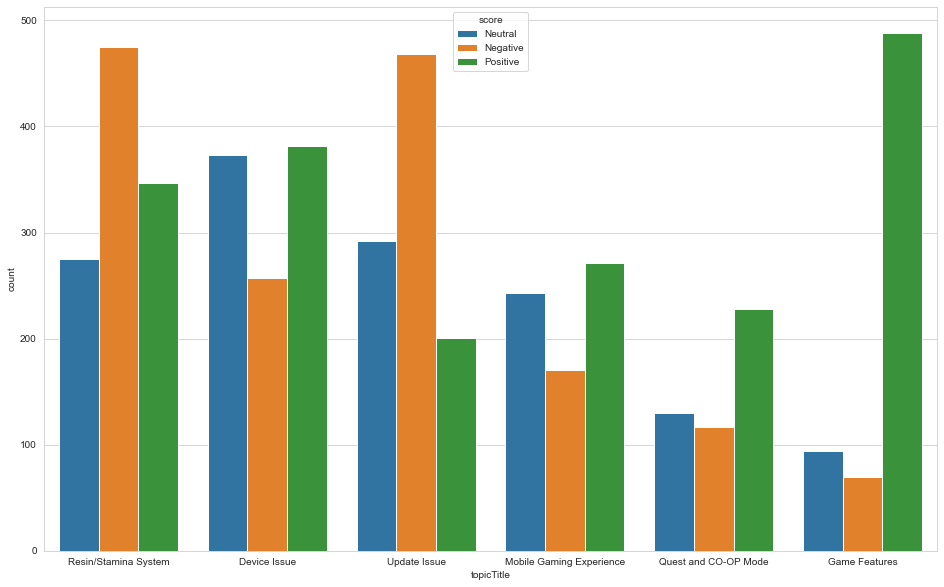

In [32]:
plt.figure(figsize=(16,10))
sns.countplot(x=topicReviews['topicTitle'], hue=topicReviews['score'])
# plt.xticks(rotation=45)

In [33]:
# topicReviews[(topicReviews.topic == 5) & (topicReviews.score == 'Positive')].sort_values('topicContribution',ascending=0)

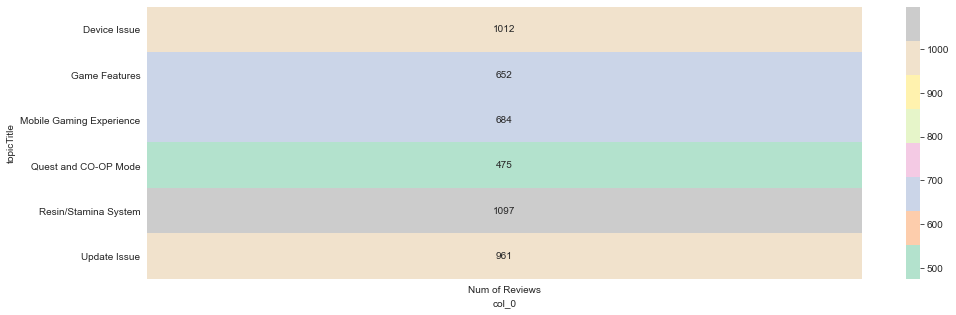

In [34]:
plt.figure(figsize=(16,5))
sns.heatmap(pd.crosstab(index=topicReviews['topicTitle'],columns=['Num of Reviews']),annot=True,fmt='',cmap='Pastel2')
plt.show()

In [35]:
data.sentiment_score.value_counts()

Positive    2147
Negative    1714
Neutral     1545
Name: sentiment_score, dtype: int64

# Conclusion

- There are 2147 Positive Reviews, 1714 Negative Reviews and 1545 Neutral Reviews
- From Gensim LDA models, there are 10 generated topics :
    0. : "Resin/Stamina System",
    1. : "Quest and CO-OP Mode",
    2. : "Update Issue",
    3. : "Device Issue",
    4. : "Mobile Gaming Experience",
    5. : "Game Features"
    
- 2 most frequent topics are "Device Issue" with 1015 Reviews and "Resin/Stamina System" with 1097 Reviews
- The least frequent topics are "Quest and Co-Op Mode" with 475 Reviews.
- "Resin/Stamina System", and "Update Issue" were dominated by Negative Reviews
- Game Features has the highest Positive Reviews percentage. Player loves this game's graphics, gameplay and game design.

# Recommendation

1. For "Resin/Stamina System", player complained about resin/stamina system obstructing game progress. Player need to spend game currency that cost real money to refill stamina. it is recomended to increase stamina recharge rate or daily cap so player can increase their playtime and make further progress on their game.

2. For "Update" issue, players complained about the size of update which "too big" for them and low download speed while downloading update package. It's recomended to compress upgrade package and increase server capacity everytime update is available for download if possible.